In [2]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torchvision
import cv2
import torch
import torch.nn
import pandas as pd 
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm, trange
import math
import numpy as np
from VisionTransformer import ViTForClassfication

In [4]:
train_df = pd.read_csv('./data/MURA-v1.1/train_labels.csv')
val_df = pd.read_csv('./data/MURA-v1.1/valid_labels.csv')

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, annotation_df , config, transform=None, target_transform=None):
        self.img_labels = annotation_df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.loc[idx, 'image_dir']
        if config['channels'] == 1:
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = torch.tensor(image, dtype= torch.float32).unsqueeze(0)
        else:
            image = cv2.imread(img_path)
            image = np.transpose(image, (2, 0, 1))
            image = torch.tensor(image, dtype= torch.float32)
        label = self.img_labels.loc[idx, 'fractured']
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Custom VIT Model

In [ ]:
label_df = pd.read_csv('./data/BoneFracture_localization.v2i.coco/annotation.csv')
# Upsample fractured samples in training data

# Separate fractured and unfractured samples
fractured_df = label_df[label_df['fractured'] == 1]
unfractured_df = label_df[label_df['fractured'] == 0]
# unfractured_df = unfractured_df.iloc[:fractured_df.shape[0], :]

# Split the fractured and unfractured data into training and validation sets
train_frac_df, val_frac_df = train_test_split(fractured_df, test_size=0.2)
train_unfrac_df, val_unfrac_df = train_test_split(unfractured_df, test_size=0.2)

num_unfrac = len(train_unfrac_df)
num_frac = len(train_frac_df)

if num_frac < num_unfrac:
    # Calculate how many more fractured samples are needed
    difference = num_unfrac - num_frac
    
    # Upsample fractured data by duplicating random samples with replacement
    upsampled_train_frac_df = train_frac_df.sample(difference, replace=True, random_state=42)
    
    # Concatenate the upsampled fractured samples with the original fractured data
    train_frac_df = pd.concat([train_frac_df, upsampled_train_frac_df])

# Concatenate upsampled fractured data with unfractured data
train_df = pd.concat([train_frac_df, train_unfrac_df])

# Concatenate validation sets without upsampling
val_df = pd.concat([val_frac_df, val_unfrac_df])

# Reset index for both train and validation dataframes
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

# Shuffle the training set
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df['image_dir'] = train_df['image_dir'].apply(lambda x: './data/BoneFracture_localization.v2i.coco/train/' + x)
val_df['image_dir'] = val_df['image_dir'].apply(lambda x: './data/BoneFracture_localization.v2i.coco/train/' + x)
# val_df = val_df[val_df['fractured'] == 1]
# val_df.shape

Feature batch shape: torch.Size([64, 3, 500, 500])


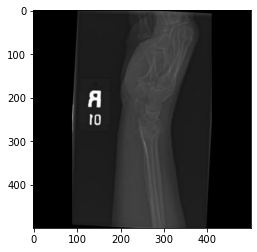

Label: 1


In [40]:
# Configuration for the ViT model (you can adjust these as per your model design)
config = {
    "encoding_size": 256,
    "num_classes": 2,
    "num_heads": 4,
    "img_dim": 500,
    "patch_size": 20,
    "dropout": 0.2,
    'num_hidden_layers': 2,
    'intermediate_size': 512,
    'channels': 3,
    'train_batch_size': 64
}

transform = transforms.Compose([
    transforms.Resize(config['img_dim']),
    transforms.CenterCrop(config['img_dim']),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(30),  # Randomly rotate the image
#     transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Adjust brightness and contrast
    transforms.Normalize(mean=[0.5], std=[0.5])
    
])


train_dataset = CustomImageDataset(train_df, config, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=config['train_batch_size'], shuffle=True)

val_dataset = CustomImageDataset(val_df, config, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=config['train_batch_size'], shuffle=True)


train_features, train_labels = next(iter(val_dataloader))
print(f"Feature batch shape: {train_features.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img[0], cmap="gray")
plt.show()
print(f"Label: {label}")

In [26]:
from sklearn.metrics import roc_auc_score

def train(N_EPOCHS, criterion, optimizer, model, config):
    # Training loop
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        iteration = 0  # To track the number of iterations
        train_correct = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1} in training", leave=False):
            iteration += 1

            # Training Step
            x, y = batch
            x, y = x.cuda(), y.cuda()  # Assuming you're using a GPU
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_dataloader)
            _, predicted = torch.max(y_hat, 1)
            train_correct += (predicted == y).sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Validation step after every 10 iterations
            if iteration % 10 == 0:
                val_loss = 0.0
                correct = 0
                total = 0
                all_val_labels = []
                all_val_probs = []

                model.eval()  # Set the model to evaluation mode
                with torch.no_grad():  # Disable gradient computation
                    for val_batch in tqdm(val_dataloader):
                        val_x, val_y = val_batch
                        val_x, val_y = val_x.cuda(), val_y.cuda()

                        val_y_hat = model(val_x)
                        val_loss += criterion(val_y_hat, val_y).item() / len(val_dataloader)

                        # Calculate accuracy
                        _, predicted = torch.max(val_y_hat, 1)
                        correct += (predicted == val_y).sum().item()
                        total += val_y.size(0)

                        # Store probabilities and labels for AUC calculation
                        all_val_labels.extend(val_y.cpu().numpy())
                        all_val_probs.extend(val_y_hat.softmax(dim=1)[:, 1].cpu().numpy())  # Taking probability for class 1

                # Compute AUC for validation
                val_accuracy = correct / total
                val_auc = roc_auc_score(all_val_labels, all_val_probs)
                
                train_accuracy = train_correct / (iteration*config['train_batch_size'])
#                 print(f"Iteration {iteration}: Validation Loss: {val_loss:.2f}, Validation Accuracy: {val_accuracy:.2f}")
                model.train()  # Switch back to training mode
                print(f"Iteration {iteration}: Training Loss: {loss:.2f}, Training Accuracy: {train_accuracy:.2f}")

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

In [ ]:
from torchvision import models

# resnet = models.resnet50(pretrained=True)
# num_ftrs = resnet.fc.in_features
# resnet.fc = nn.Linear(num_ftrs, 2)  
# resnet = resnet.cuda()

N_EPOCHS = 5

# # Model (replace `ViTForClassification` with your actual ViT class name)
vit = ViTForClassfication(config)
vit = vit.cuda()  

optimizer = AdamW(vit.parameters(), lr=1e-3, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

train(N_EPOCHS, criterion, optimizer, vit, config)

# Huggingface Pipeline

In [3]:
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments, AutoFeatureExtractor
from datasets import load_dataset, Dataset, concatenate_datasets
from transformers import ViTForImageClassification, AutoImageProcessor, CvtForImageClassification
from PIL import Image
import torch
from PIL import Image
import random
# import torchvision.transforms as T



# Load the data from CSV
data_files = {"train": "./data/MURA-v1.1/train_labels.csv",
              "valid": "./data/MURA-v1.1/valid_labels.csv"}  # update with the correct path
dataset = load_dataset("csv", data_files=data_files)


# processor = AutoImageProcessor.from_pretrained("KhalfounMehdi/vision_transformer_mura_model_v3")
# model = AutoModelForImageClassification.from_pretrained("KhalfounMehdi/vision_transformer_mura_model_v3")


# model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)
# processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", num_labels=2, ignore_mismatched_sizes=True)

processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-384", num_labels=2, ignore_mismatched_sizes=True)
model = AutoModelForImageClassification.from_pretrained("D3STRON/bone_fracture_vit", num_labels=2, ignore_mismatched_sizes=True)


# feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-21-384-22k', num_labels=2, ignore_mismatched_sizes=True)
# model = CvtForImageClassification.from_pretrained('microsoft/cvt-21-384-22k', num_labels=2, ignore_mismatched_sizes=True)

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [4]:
def preprocess_data(examples):
    images = []
    for image_path in examples["image_dir"]:
        image = Image.open(image_path).convert("RGB")
        augmented_image = image
        images.append(augmented_image)
    
    # Convert the list of images to tensors
    inputs = processor(images=images, return_tensors="pt")
    inputs["labels"] = examples["fractured"]
    return inputs

# Apply the preprocessing function
prepared_dataset = dataset["train"].map(preprocess_data, batched=True, batch_size=16) 
valid_dataset = dataset["valid"].map(preprocess_data, batched=True, batch_size=16)

In [17]:
import logging
logging.basicConfig(level=logging.INFO)
import evaluate
import numpy as np
os.environ["WANDB_DISABLED"] = "true"

# Load the accuracy metric
accuracy_metric = evaluate.load("accuracy")
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
#     return accuracy


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute basic metrics
    precision = precision_score(labels, predictions, average="binary")
    recall = recall_score(labels, predictions, average="binary")
    f1 = f1_score(labels, predictions, average="binary")
    
    # Compute AUC
    if len(np.unique(labels)) == 2:  # AUC is valid only for binary classification
        probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)
        auc = roc_auc_score(labels, probabilities[:, 1])
    else:
        auc = None
    
    # Confusion matrix
    conf_matrix = confusion_matrix(labels, predictions)

    # Log metrics
    logging.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc if auc is not None else 'N/A'}")
    logging.info(f"Confusion Matrix:\n{conf_matrix}")
    logging.info(f"Accuracy:\n{accuracy_metric.compute(predictions=predictions, references=labels)['accuracy']}")
    return accuracy_metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="bone_fracture_vit",                    # Directory to save the model
    per_device_train_batch_size=16,             # Adjust batch size as needed
    per_device_eval_batch_size=32,
    num_train_epochs=4,                        # Number of epochs
    save_steps=1000,                            # Save checkpoint every 500 steps
    learning_rate=1e-5,
    weight_decay=0.0002,                         # Weight decay for regularization
    logging_strategy='steps',                  # Log at each step interval
    report_to="all",                           # Enable logging to console
    evaluation_strategy='steps',
    eval_steps=1000,
    warmup_ratio=0.2,                          # 10% of total steps for warmup
    lr_scheduler_type="cosine",                # Learning rate decay strategy
    save_total_limit=1,                        # Keep only the last 2 checkpoints
    push_to_hub=True
)

# Define the Trainer with model, arguments, and dataset
trainer = Trainer(
    model=model,  
    args=training_args,
    train_dataset=prepared_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

C:\Users\GHOSH\OneDrive\Documents\MS\NEU\Assignmnets\CS5330\Project\detr\lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
trainer.train()

In [18]:
# Evaluate the model

eval_results = trainer.evaluate()

# Log evaluation results
logging.info(f"Evaluation Results: {eval_results}")

INFO:root:Precision: 0.8631, Recall: 0.7379, F1: 0.7956, AUC: 0.8798777499402081
INFO:root:Confusion Matrix:
[[1488  179]
 [ 401 1129]]
INFO:root:Accuracy:
0.8185799186737567
INFO:root:Evaluation Results: {'eval_loss': 0.45629775524139404, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.8185799186737567, 'eval_runtime': 779.5271, 'eval_samples_per_second': 4.101, 'eval_steps_per_second': 0.128}
